In [1]:
%load_ext autoreload
%autoreload 2

import os
import multiprocessing

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

import gpjax as gpx
import blackjax
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from gpjax.kernels import RBF, Linear, Periodic, PoweredExponential
from jaxoplanet.light_curves import LimbDarkLightCurve
import optax
from corner import corner

from jaxoplanet import orbits


from kernels import OrnsteinUhlenbeck
from kernelsearch import KernelSearch, describe_kernel, get_trainables
from inference import log_likelihood_function, run_inference_algorithm

rng_key = jax.random.PRNGKey(42)

In [2]:
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

## CREATE ARTIFICAL DATA

In [3]:
@jit
def calculate_lightcurve(t, params):
    # The light curve calculation requires an orbit
    orbit = orbits.keplerian.Body(
        period=params["period"],
        radius=params["radius"],
        inclination=params["inclination"],
        time_transit=params["time_transit"],
    )

    lc = LimbDarkLightCurve(params["u"]).light_curve(orbit, t=t)
    return lc

In [4]:
t = jnp.linspace(-0.8, 0.8, 1000)

true_params = {
    "period": 15,  # period in days
    "radius": 0.1,
    "inclination": jnp.deg2rad(89),
    "time_transit": 0,
    "u": jnp.array([0.1, 0.3]),
}


true_lightcurve = calculate_lightcurve(
    t=t,
    params=true_params,
)

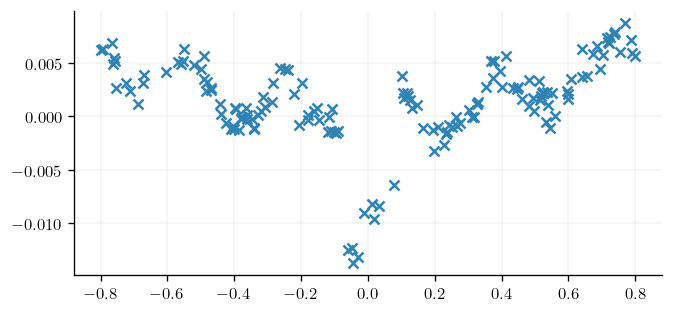

In [5]:
# create noisy lightcurve
num_points = 150
rng_key, idx_key, noise_key = jax.random.split(rng_key, 3)
noise_std = 0.001

test_ind = jnp.sort(jax.random.choice(idx_key, len(t), (num_points,), replace=False))
t_train = t[test_ind]
lc_latent = true_lightcurve + 0.002 * (
    5 * t**2 + jnp.sin(20 * t) + 0.3 * jnp.cos(50 * t)
)
lc_latent_wo_lc = lc_latent - true_lightcurve
lc_train = lc_latent[test_ind] + noise_std * jax.random.normal(noise_key, (num_points,))

mask = jnp.array(~np.ma.masked_where((-0.1 < t_train) & (t_train < 0.1), t_train).mask)

plt.scatter(t_train, lc_train)

## PERFORM KERNEL SEARCH

In [6]:
kernel_library = [
    Linear(),
    RBF(),
    OrnsteinUhlenbeck(),
    Periodic(),
    # PoweredExponential(power=jnp.array(0.5)), # default powered exponential has infinite parameter for some reason
]

In [7]:
tree = KernelSearch(
    kernel_library,
    X=jnp.array(t_train[mask]),
    y=jnp.array(lc_train[mask]),
    obs_stddev=noise_std,
    verbosity=1,
)

model = tree.search(
    depth=7,
    n_leafs=4,
    patience=1,
)

Fitting Layer 1: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


Layer 1 || Current AICs: [-1415.0782182675418, -1309.2560009117733, -1259.3718657815725, -759.8564458698909]


Fitting Layer 2: 100%|██████████| 32/32 [00:47<00:00,  1.47s/it]


Layer 2 || Current AICs: [-1443.1001292384071, -1433.2682699359077, -1433.2682699359052, -1430.107198476329, -1429.1642975778166, -1428.441526312117, -1428.3169716173547, -1425.8050517817296, -1425.8050517817285, -1425.6469368422204, -1413.0782182675418, -1413.0782182675412, -1413.0782182657704, -1413.0782182186194, -1413.0782179109822, -1411.7747622399593, -1411.7747621812268, -1411.0782182675334, -1405.1842426283224, -1405.1842426283172, -1325.3464962379333, -1319.2962593756629, -1319.2962593756379, -1307.2560009117187, -1307.256000902111, -1307.2560008087555, -1305.4203916124216, -1295.2150464384345, -1295.215046438434, -1257.410033938192, -1257.4100339381919, -757.8564458698902]


Fitting Layer 3: 100%|██████████| 44/44 [03:48<00:00,  5.19s/it]


Layer 3 || Current AICs: [-1447.634726983769, -1441.7872884371068, -1441.7872884371043, -1441.1001292382393, -1441.1001292382227, -1441.10012923818, -1439.787288437114, -1439.787287878606, -1439.1001292384105, -1439.100129238408, -1439.1001292384053, -1438.2418715649899, -1438.2418715649897, -1433.0449839968294, -1431.2682699359084, -1431.2682699359073, -1431.2682699358975, -1431.2682699358913, -1431.268269935878, -1431.2682699358686, -1431.2682699358672, -1431.268269935863, -1429.690723490451, -1429.6907234024816, -1429.2682699359075, -1429.2682699359073, -1429.268269935907, -1429.2682699359068, -1429.268269935896, -1429.2682699358918, -1428.1071984763225, -1428.1071984762968, -1428.1071984741625, -1427.6907342747825, -1427.6907342740744, -1427.36583801987, -1427.3658380053462, -1426.1071984763296, -1425.390260378882, -1420.4279777135525, -1420.4279746992827, -1419.7582215477714, -1412.248491749093, inf]


Fitting Layer 4: 100%|██████████| 48/48 [04:09<00:00,  5.19s/it]


Layer 4 || Current AICs: [-1456.4681257837187, -1447.6347271415116, -1447.6347271415093, -1445.6347271060206, -1445.6347270054002, -1445.634726983911, -1445.6347269837477, -1445.6347269817816, -1445.6347269811633, -1443.634726983907, -1443.634726983899, -1443.6347269838886, -1443.6347269838666, -1443.6168110640338, -1443.6168110640176, -1439.7872884371056, -1439.7872884371025, -1439.7872884370918, -1439.7872884370902, -1439.787288437087, -1439.7872884370865, -1439.7872884370809, -1439.7872884370745, -1439.7872884370572, -1439.7872884370245, -1439.1001292382332, -1439.1001292382255, -1439.1001292381852, -1439.1001292381452, -1439.1001292380186, -1437.7872884371136, -1437.7872884371095, -1437.7872884371034, -1437.7872884371009, -1437.7872884370993, -1437.7872884370847, -1437.7872884369244, -1437.787287152172, -1437.1001292382402, -1437.1001292382396, -1437.100129238235, -1434.7573534540743, -1431.0449839968142, -1421.9731640399652, -1421.9731639467814, -1421.0838898222557, -1410.24849174

Fitting Layer 5: 100%|██████████| 48/48 [04:20<00:00,  5.42s/it]


Layer 5 || Current AICs: [-1456.4681257836717, -1456.4681257836662, -1454.8750778968551, -1454.4681257836942, -1454.468125783665, -1454.4681257836617, -1454.468125783643, -1454.4681257835634, -1454.4681257829777, -1452.4681257837228, -1452.4681257836996, -1452.4681257836946, -1452.468090313681, -1445.6347271415111, -1445.6347271415082, -1445.6347271414932, -1445.6347271414886, -1445.634727141484, -1445.6347271414813, -1445.6347271414409, -1445.6347271414377, -1445.6347271413858, -1445.6347271413106, -1445.494262361778, -1445.4942623617642, -1443.634727141508, -1443.6347271415032, -1443.634727141486, -1443.6347271414666, -1443.6347271414647, -1443.6347271414477, -1443.6347271414425, -1443.63472714134, -1443.6347271413347, -1443.6347271290083, -1443.6347269887508, -1443.6347269832806, -1443.6347269816779, -1443.4942623365612, -1441.6347271319373, -1441.6347271066345, -1441.6347271007103, -1441.6347269838393, -1423.8141082364984, -1421.9731679530344, -1417.7582221706978, -1417.75822167236

Fitting Layer 6: 100%|██████████| 48/48 [05:28<00:00,  6.83s/it]

Layer 6 || Current AICs: [-1454.8750778969263, -1454.8750778968795, -1454.8750778968724, -1454.4681257836558, -1454.4681257836362, -1454.4681257836014, -1454.468125783591, -1454.468125783588, -1454.4681257835748, -1454.4681257835712, -1454.4681257835703, -1454.4681257835587, -1454.4681257835168, -1452.8750778969, -1452.8750778968513, -1452.8750778968513, -1452.8750778968345, -1452.8750778966742, -1452.875077755831, -1452.4681833254433, -1452.4681257836712, -1452.4681257836662, -1452.468125783653, -1452.4681257836444, -1452.468125783642, -1452.468125783637, -1452.4681257836212, -1452.4681257836157, -1452.4681257835982, -1452.4681257835832, -1452.4681257835018, -1452.4681195161509, -1450.875077896859, -1450.8750778967863, -1450.8750778966494, -1450.8750778963724, -1450.4681833166726, -1450.4681257836814, -1450.4681257836648, -1450.46812578358, -1437.1758446265342, -1423.8141082365073, -1423.814108236506, -1421.9731678837766, -1421.9731678357161, -1421.8141082365014, -1419.9731678697465, 

In [8]:
describe_kernel(model)

'Periodic + (Periodic * Linear * Linear)'

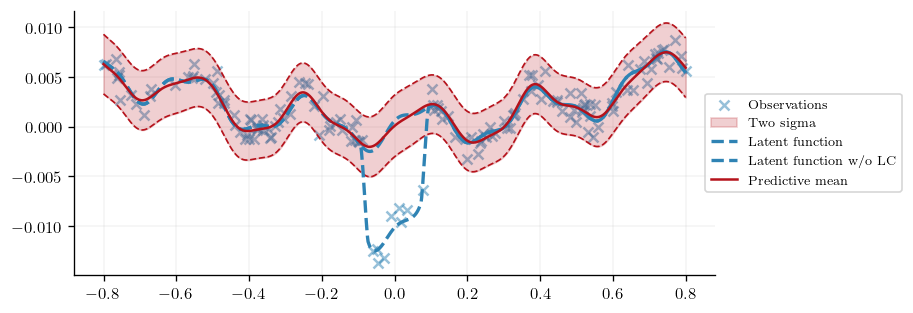

In [9]:
latent_dist = model(t.reshape(-1, 1), train_data=tree.data)
predictive_dist = model.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.scatter(t_train, lc_train, label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    t,
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    t,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    t,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    t,
    lc_latent,
    label="Latent function",
    color=cols[0],
    linestyle="--",
    linewidth=2,
)
ax.plot(
    t,
    lc_latent_wo_lc,
    label="Latent function w/o LC",
    color=cols[0],
    linestyle="--",
    linewidth=2,
)
ax.plot(t, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))

## FIT LC

In [10]:
@jit
def lc_model(t, params):
    # The light curve calculation requires an orbit
    orbit = orbits.keplerian.Body(
        period=15,
        radius=params[0],
        inclination=jnp.deg2rad(89),
        time_transit=0,
    )

    lc = LimbDarkLightCurve([params[1], params[2]]).light_curve(orbit, t=t)
    return lc

In [21]:
from tensorflow_probability.substrates.jax.distributions import Normal, Uniform

gp_initial_params = get_trainables(model, unconstrain=True)
lc_initial_params = jnp.asarray([0.2, 0.2, 0.5])

initial_params = {
    "gp_parameter": get_trainables(model, unconstrain=True),
    "lc_parameter": lc_initial_params,
}

gp_param_bounds = (
    -jnp.inf * jnp.ones_like(gp_initial_params),
    jnp.inf * jnp.ones_like(gp_initial_params),
)
lc_param_bounds = (jnp.array([0.0, 0.0, 0.0]), jnp.array([1.0, 1.0, 1.0]))
lower_param_bounds = {
    "gp_parameter": gp_param_bounds[0],
    "lc_parameter": lc_param_bounds[0],
}
upper_param_bounds = {
    "gp_parameter": gp_param_bounds[1],
    "lc_parameter": lc_param_bounds[1],
}

gp_parameter_priors = Normal(loc=gp_initial_params, scale=1)
lc_parameter_priors = Uniform(
    low=lc_param_bounds[0],  # type: ignore
    high=lc_param_bounds[1],  # type: ignore
)
param_priors = {
    "gp_parameter": gp_parameter_priors,
    "lc_parameter": lc_parameter_priors,
}

In [39]:
log_likelihood = log_likelihood_function(
    model.unconstrain(),
    lc_model,
    t_train,
    lc_train,
    mask,
    fix_gp=True,
    compile=True,
)


@jit
def log_priors(params):
    gp_log_priors = param_priors["gp_parameter"].log_prob(params["gp_parameter"])
    lc_log_priors = param_priors["lc_parameter"].log_prob(params["lc_parameter"])
    print(gp_log_priors, lc_log_priors)
    return jnp.sum(gp_log_priors) + jnp.sum(lc_log_priors)


@jit
def log_probability(params):
    return log_likelihood(params) + log_priors(params)

In [41]:
neg_log_probability = jit(lambda params: -log_probability(params))

from jaxopt import ScipyBoundedMinimize

lbfgsb = ScipyBoundedMinimize(fun=neg_log_probability, method="l-bfgs-b")
lbfgsb_sol = lbfgsb.run(initial_params, bounds=(lower_param_bounds, upper_param_bounds))

Traced<ShapedArray(float64[6])>with<DynamicJaxprTrace(level=6/1)> Traced<ShapedArray(float64[3])>with<DynamicJaxprTrace(level=6/1)>


In [42]:
lbfgsb_sol.params

{'gp_parameter': Array([-1.59057322e+00, -1.78543246e-01, -1.25552628e+01,  3.52602417e+02,
         1.66280137e+04, -9.26515474e+00], dtype=float64),
 'lc_parameter': Array([0.09935107, 0.        , 0.        ], dtype=float64)}

## RUN MCMC

In [43]:
# Adapted from BlackJax's introduction notebook.
num_adapt = 10000
num_samples = 10000
num_chains = 8

warmup = blackjax.window_adaptation(
    blackjax.nuts,
    log_probability,
    target_acceptance_rate=0.65,
    progress_bar=True,
)
rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)
(state, parameters), _ = warmup.run(
    warmup_key,
    initial_params,
    num_steps=num_adapt,
)

Running window adaptation


In [35]:
nuts = blackjax.nuts(log_probability, **parameters)

initial_positions = {
    "gp_parameter": jnp.tile(state.position["gp_parameter"], (num_chains, 1)),
    "lc_parameter": jnp.tile(state.position["lc_parameter"], (num_chains, 1)),
}

initial_states = jax.vmap(nuts.init, in_axes=(0))(initial_positions)

inference_loop_multiple_chains = jax.pmap(
    run_inference_algorithm,
    in_axes=(0, 0, None, None, None),
    static_broadcasted_argnums=(2, 3, 4),
)
sample_keys = jax.random.split(sample_key, num_chains)

In [36]:
pmap_states = inference_loop_multiple_chains(
    sample_keys,
    initial_states,
    nuts,
    num_samples,
    False,
)

Traced<ShapedArray(float64[6])>with<DynamicJaxprTrace(level=8/1)> Traced<ShapedArray(float64[3])>with<DynamicJaxprTrace(level=8/1)>


In [37]:
from inference import run_inference_algorithm

states = run_inference_algorithm(
    sample_key,
    state,
    nuts,
    num_samples,
    True,
)

/home/chris/mambaforge/envs/hobby/lib/python3.10/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


Done


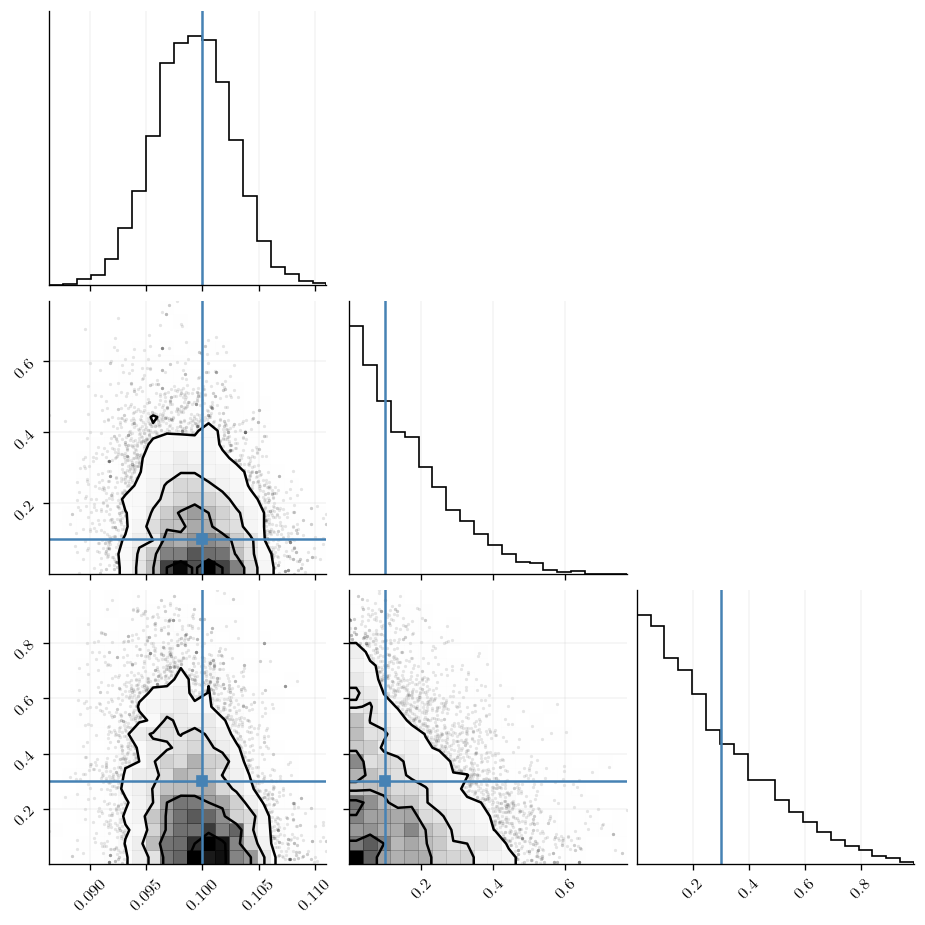

In [38]:
corner(np.array(states[1].position["lc_parameter"]), truths=[0.1, 0.1, 0.3])
print("Done")